In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as T
import torchvision.datasets as datasets 
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import pandas as pd
import shutil

plt.rcParams['figure.figsize'] = (8, 8)

### 1. Подготовка данных для распознавания

In [2]:
# Каталог с набором данных 
data_dir = './TT_Person_dataset/'
# Каталог с данными для обучения
train_dir = 'trainset'
# Каталог с данными для тестирования
test_dir = 'testset'
# Часть набора данных для тренировки
train_data_portion = 0.6
# Часть набора данных для тестирования
test_data_portion = 0.4
# Количество элементов данных в одном классе neg
nb_neg_images= len(os.listdir('./TT_Person_dataset/neg/'))
print(nb_neg_images)
# Количество элементов данных в одном классе pos
nb_pos_images = len(os.listdir('./TT_Person_dataset/pos/'))
print(nb_pos_images)

1671
902


In [3]:
# Создаем функцию для каталогов train/test c папками pos/neg в каждой из них
def create_directory(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    else:
        os.makedirs(os.path.join(data_dir, dir_name, 'pos'))
        os.makedirs(os.path.join(data_dir, dir_name, 'neg'))

In [4]:
# Создаем директорию
create_directory(train_dir)
create_directory(test_dir)

In [5]:
# Расчет индексов наборов данных для обучения и тестирования
train_data_pos_idx = int(nb_pos_images * (1-test_data_portion))
train_data_neg_idx = int(nb_neg_images * (1-test_data_portion))

test_data_pos_idx = int(nb_pos_images * (1-train_data_portion))
test_data_neg_idx = int(nb_neg_images * (1-train_data_portion))

# train
train_data_pos_idx = os.listdir('./TT_Person_dataset/pos/')[:train_data_pos_idx]
train_data_neg_idx = os.listdir('./TT_Person_dataset/neg/')[:train_data_neg_idx]

#test
test_data_pos_idx = os.listdir('./TT_Person_dataset/pos/')[-test_data_pos_idx-1:]
test_data_neg_idx = os.listdir('./TT_Person_dataset/neg/')[-test_data_neg_idx-1:]
                                                           
print(len(train_data_pos_idx))
print(len(train_data_neg_idx))
print(len(test_data_pos_idx))
print(len(test_data_neg_idx))

541
1002
361
669


In [6]:
# Распределяем изображения из pos/neg в каталоги train/test в пропорции 60/40
def copy_pos_images(data_pos_idx, source_dir, dest_dir):
    for i in data_pos_idx:
        shutil.copy(os.path.join(source_dir,'pos/', i), os.path.join(dest_dir, 'pos/'))

def copy_neg_images(data_neg_idx, source_dir, dest_dir):
    for i in data_neg_idx:
        shutil.copy(os.path.join(source_dir,'neg/', i), os.path.join(dest_dir, 'neg/'))

In [7]:
# Копирование изображений для train
dest_train_dir = './TT_Person_dataset/trainset/'
copy_pos_images(train_data_pos_idx, data_dir, dest_train_dir)
copy_neg_images(train_data_neg_idx, data_dir, dest_train_dir)

In [8]:
# Копирование изображений для test
dest_test_dir = './TT_Person_dataset/testset/'
copy_pos_images(test_data_pos_idx, data_dir, dest_test_dir)
copy_neg_images(test_data_neg_idx, data_dir, dest_test_dir)

### 2. Трансформируем наш датасет

In [9]:
transform = T.Compose([
    T.Resize(120),
    #T.RandomCrop(224),
    T.ToTensor(),
    T.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
])

trainset_root = './TT_Person_dataset/trainset/'
testset_root = './TT_Person_dataset/testset/'

trainset = torchvision.datasets.ImageFolder(trainset_root, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle = True, num_workers=2)

testset = torchvision.datasets.ImageFolder(testset_root, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle = False, num_workers = 2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 120, 120])
torch.Size([4, 3, 120, 120])
torch.Size([4])


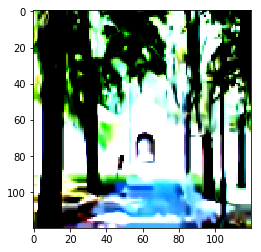

In [10]:
# Размерность trainloader/testloader
dataiter = iter(trainloader)
images, labels = next(dataiter)
                      
x, y = trainset[5]
plt.imshow(x.numpy().transpose((1, 2, 0)))
print(x.shape)
print(images.shape)
print(labels.shape)

### 3. Определение модели сверточной нейронной сети

In [120]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.conv3 = nn.Conv2d(32,120, 5)
        self.global_pool = nn.MaxPool2d(23, 23)
        
        self.l1 = nn.Linear(120, 64)
        self.l2 = nn.Linear(64, 32)
        self.l3 = nn.Linear(32,2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.global_pool(x)
        x = x.view(-1, 120)
       
        x = F.relu(self.l1(x))
        x = F.relu(self.l2(x))
        x = self.l3(x)
        
        return x

In [121]:
class Mean(object):
    def __init__(self):
        self.values = []

    def compute(self):
        return sum(self.values) / len(self.values)

    def update(self, value):
        self.values.extend(np.reshape(value, [-1]))

    def reset(self):
        self.values = []

    def compute_and_reset(self):
        value = self.compute()
        self.reset()

        return value

def accuracy(a, b):
    return (a == b).float().mean()

### 4. Реализация модели и вывод accuracy/loss






  0%|                                                   | 0/10 [00:00<?, ?it/s]

epoch 0, train loss 0.62,train acc 0.65
epoch 0, test loss 0.59,test acc 0.65


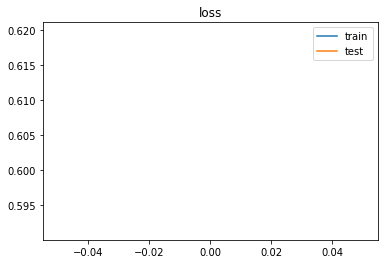

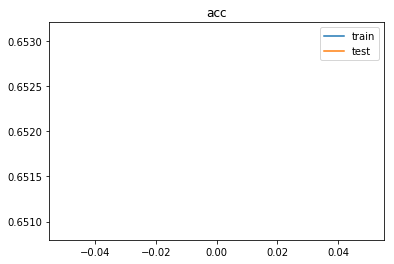






 10%|████▏                                     | 1/10 [04:07<37:10, 247.85s/it]

epoch 1, train loss 0.42,train acc 0.81
epoch 1, test loss 0.60,test acc 0.67


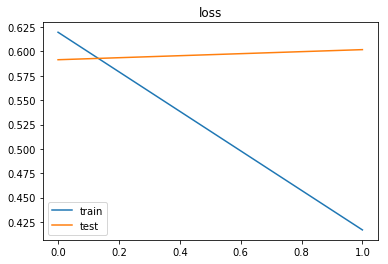

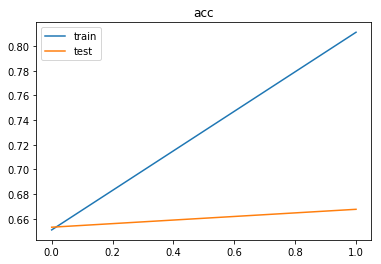






 20%|████████▍                                 | 2/10 [10:11<37:41, 282.65s/it]

epoch 2, train loss 0.34,train acc 0.87
epoch 2, test loss 0.61,test acc 0.66


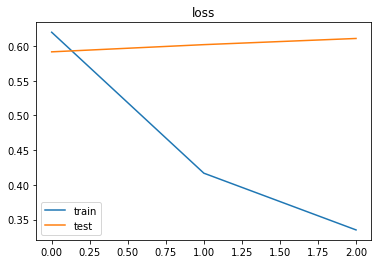

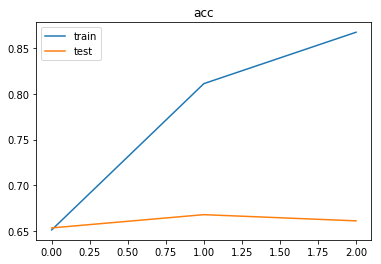






 30%|████████████▌                             | 3/10 [14:23<31:54, 273.51s/it]

epoch 3, train loss 0.30,train acc 0.88
epoch 3, test loss 0.55,test acc 0.69


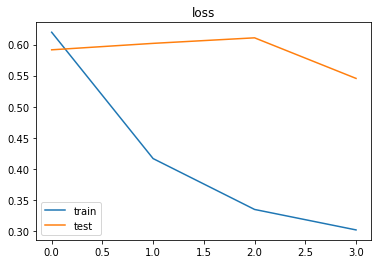

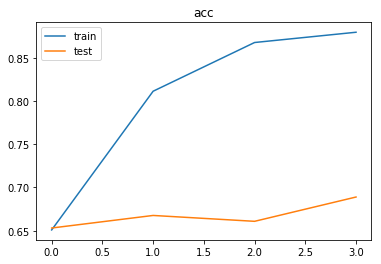






 40%|████████████████▊                         | 4/10 [24:40<37:38, 376.37s/it]

epoch 4, train loss 0.27,train acc 0.89
epoch 4, test loss 0.66,test acc 0.69


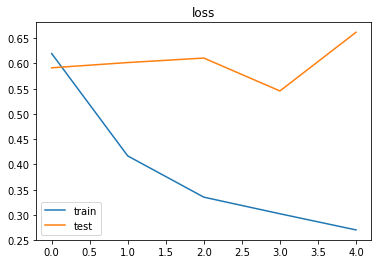

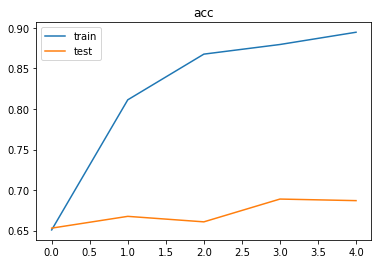






 50%|█████████████████████                     | 5/10 [33:41<35:29, 425.93s/it]

epoch 5, train loss 0.25,train acc 0.91
epoch 5, test loss 0.51,test acc 0.73


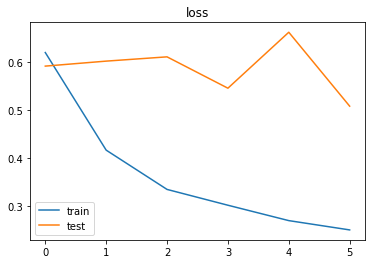

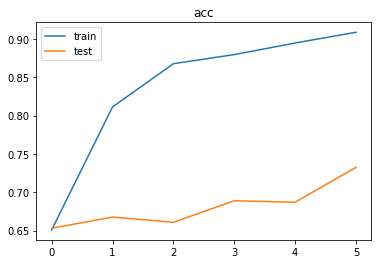






 60%|█████████████████████████▏                | 6/10 [40:33<28:06, 421.61s/it]

epoch 6, train loss 0.22,train acc 0.91
epoch 6, test loss 0.73,test acc 0.72


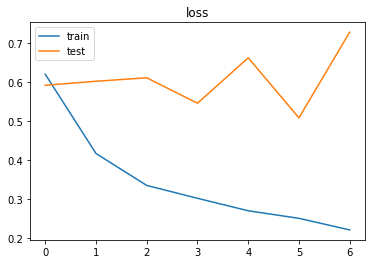

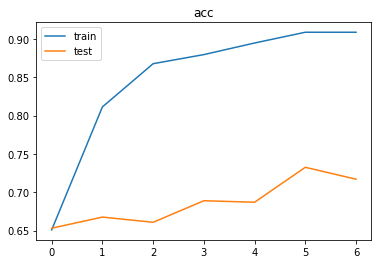






 70%|█████████████████████████████▍            | 7/10 [44:53<18:39, 373.21s/it]

epoch 7, train loss 0.26,train acc 0.90
epoch 7, test loss 0.59,test acc 0.68


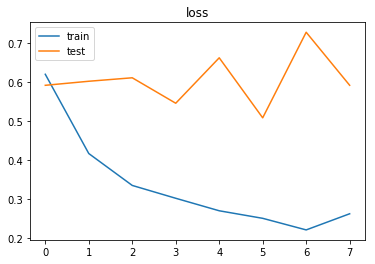

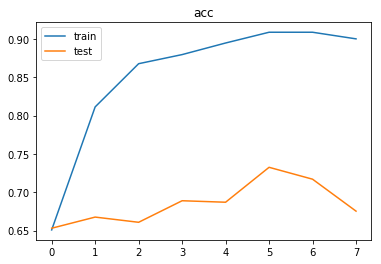






 80%|█████████████████████████████████▌        | 8/10 [49:05<11:13, 336.69s/it]

epoch 8, train loss 0.21,train acc 0.92
epoch 8, test loss 0.50,test acc 0.75


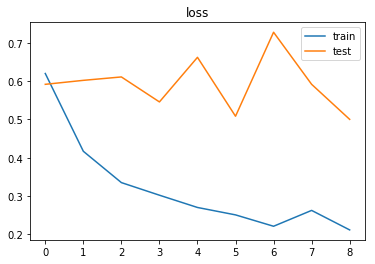

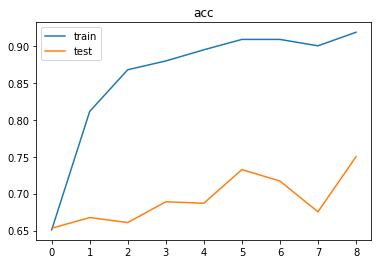






 90%|█████████████████████████████████████▊    | 9/10 [52:59<05:06, 306.00s/it]

epoch 9, train loss 0.19,train acc 0.93
epoch 9, test loss 0.57,test acc 0.75


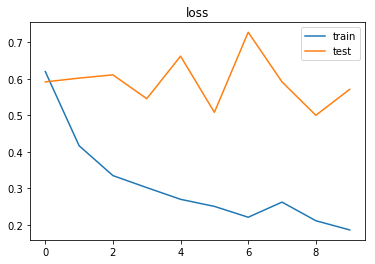

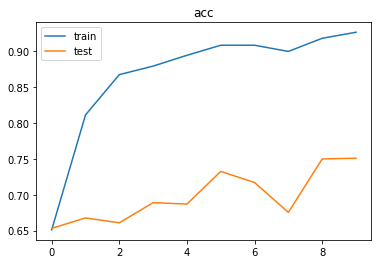






100%|█████████████████████████████████████████| 10/10 [56:53<00:00, 284.26s/it]

In [126]:
# Define Model
model = Model()
lr = 0.001  # learning rate

opt = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
#opt = torch.optim.Adam(model.parameters(), lr)
stats = {
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': []
}

# mean_loss = Mean()
# mean_acc = Mean()

for epoch in tqdm(range(10)):
    train_accs = []
    train_losses = []
    test_accs = []
    test_losses = []
    
    #model.train()
    for images, targets in trainloader: 
        logits = model(images)
        
        train_loss = F.cross_entropy(input = logits, target = targets) # Функция ошибки
        train_acc = accuracy(targets, logits.argmax(1))   
        
        train_losses.append(train_loss.data.numpy())
        train_accs.append(train_acc.data.numpy())

        opt.zero_grad()
        train_loss.backward()
        opt.step()

    train_loss = np.mean(train_losses) 
    train_acc = np.mean(train_accs)
    
    #model.test()
    for images, targets in testloader: 
        logits = model(images)
        
        test_loss = F.cross_entropy(input = logits, target = targets)
        test_acc = accuracy(targets, logits.argmax(1))   
        
        test_losses.append(test_loss.data.numpy())
        test_accs.append(test_acc.data.numpy())

    test_loss = np.mean(test_losses) 
    test_acc = np.mean(test_accs)

    
    print('epoch {}, train loss {:.2f},train acc {:.2f}'.format(epoch, train_loss,train_acc))
    stats['train_loss'].append(train_loss)
    stats['train_acc'].append(train_acc)
    
    print('epoch {}, test loss {:.2f},test acc {:.2f}'.format(epoch, test_loss,test_acc))
    stats['test_loss'].append(test_loss)
    stats['test_acc'].append(test_acc)
    
    plt.plot(stats['train_loss'], label = 'train')
    plt.plot(stats['test_loss'], label = 'test')
    plt.title('loss')
    plt.legend()
    plt.show()
    
    plt.plot(stats['train_acc'], label = 'train')
    plt.plot(stats['test_acc'], label = 'test')
    plt.title('acc')
    plt.legend()
    plt.show()